In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf

2023-06-07 08:53:17.862794: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.1 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [20]:
def balance_classes(df, column_name):
    """Balance the classes of a binary column in a dataframe."""
    counts = df[column_name].value_counts()
    # Check if classes are already balanced
    if counts.min() == counts.max():
        return df
    # Identify majority and minority classes
    majority_class = counts.idxmax()
    minority_class = counts.idxmin()
    # Randomly select instances from majority class to remove
    majority_indices = df[df[column_name] == majority_class].index
    num_instances_to_remove = len(majority_indices) - counts[minority_class]
    indices_to_remove = np.random.choice(majority_indices, size=num_instances_to_remove, replace=False)
    # Remove instances from majority class
    df = df.drop(indices_to_remove)
    return df.reset_index(drop=True)

df = pd.read_csv('data/addresses_and_tweets.csv')
df = df.drop_duplicates(subset='text').reset_index(drop=True)
df = balance_classes(df, 'is_address').sample(50000)

In [21]:
df.is_address.value_counts()

1    25143
0    24857
Name: is_address, dtype: int64

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=42) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 40000
Test Data size 10000


In [24]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 39346


In [25]:
from keras.utils import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:", x_train.shape)
print("Testing X Shape:",  x_test.shape)

Training X Shape: (40000, 30)
Testing X Shape: (10000, 30)


In [26]:
labels = train_data.is_address.unique().tolist()
labels

[1, 0]

In [27]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train_data.is_address.to_list())

y_train = encoder.transform(train_data.is_address.to_list())
y_test = encoder.transform(test_data.is_address.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)


y_train shape: (40000, 1)
y_test shape : (10000, 1)


In [10]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip

In [32]:
GLOVE_EMB = 'data/embedding/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [33]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [35]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [36]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# Model Training LSTM

In [37]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [38]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [39]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
              
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [40]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")


Training on GPU...


2023-06-07 08:55:53.714715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-07 08:55:53.714967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-07 08:55:53.715088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [41]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
40/40 [==============================] - 7s 84ms/step - loss: 0.0950 - accuracy: 0.9629 - val_loss: 0.0056 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 2/10
40/40 [==============================] - 3s 72ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0028 - val_accuracy: 0.9991 - lr: 0.0010
Epoch 3/10
40/40 [==============================] - 3s 70ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0029 - val_accuracy: 0.9991 - lr: 0.0010
Epoch 4/10
40/40 [==============================] - 3s 75ms/step - loss: 8.0389e-04 - accuracy: 0.9998 - val_loss: 0.0030 - val_accuracy: 0.9990 - lr: 0.0010
Epoch 5/10
40/40 [==============================] - 3s 70ms/step - loss: 4.7638e-04 - accuracy: 0.9998 - val_loss: 0.0033 - val_accuracy: 0.9993 - lr: 0.0010
Epoch 6/10
40/40 [==============================] - 3s 72ms/step - loss: 5.7873e-04 - accuracy: 0.9998 - val_loss: 0.0033 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 7/10
40/40 [==============================] - 3s 74ms/step

In [42]:
model.save("output/model.keras")
loaded_model = tf.keras.models.load_model("output/model.keras")

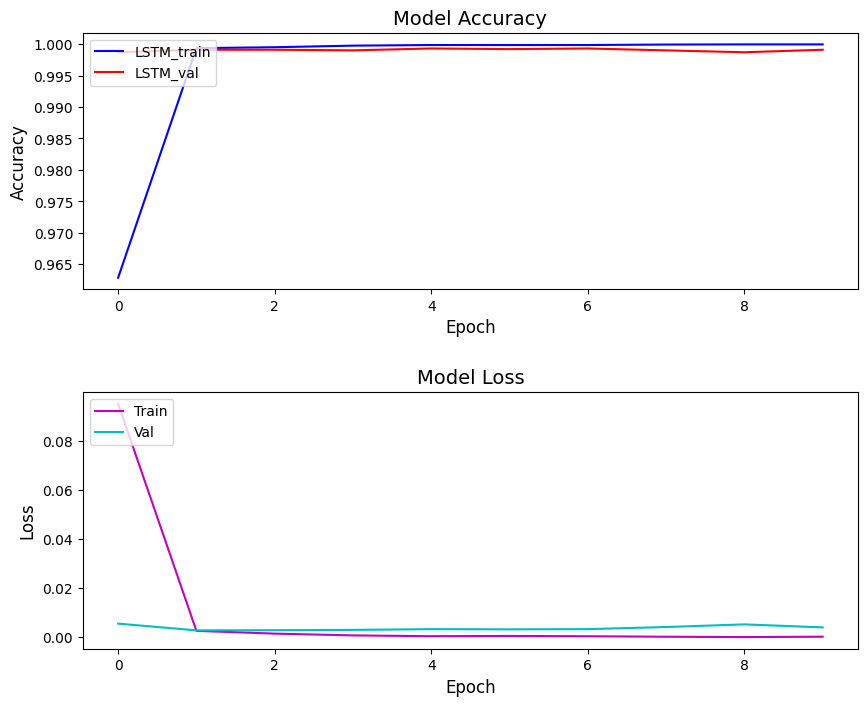

In [43]:
import matplotlib.pyplot as plt

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1)

# Plot accuracy
ax1.plot(history.history['accuracy'], c='b')
ax1.plot(history.history['val_accuracy'], c='r')
ax1.set_title('Model Accuracy', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

# Plot loss
ax2.plot(history.history['loss'], c='m')
ax2.plot(history.history['val_loss'], c='c')
ax2.set_title('Model Loss', fontsize=14)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.legend(['Train', 'Val'], loc='upper left')

# Adjust vertical spacing between subplots
fig.subplots_adjust(hspace=0.4)  # Increase the value to add more vertical margin

# Increase the image size
fig.set_size_inches(10, 8)  # Adjust the width and height as desired

# Show the plot
plt.show()


In [44]:
def decode_address(score):
    #return "Address" if score>0.5 else "Not Address"
    return 1 if score>0.5 else 0


scores = loaded_model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_address(score) for score in scores]

1/1 [==============================] - 1s 687ms/step


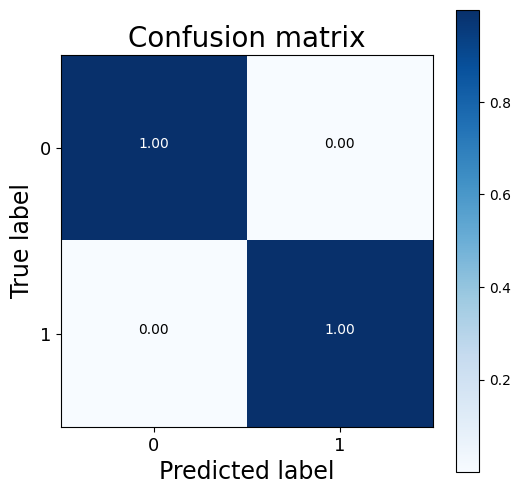

In [46]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)


cnf_matrix = confusion_matrix(test_data.is_address.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.is_address.unique(), title="Confusion matrix")
plt.show()

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression #, SGDClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc

print('AUC: ', roc_auc_score(test_data.is_address.to_list(), y_pred_1d))
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_data.is_address.to_list(), y_pred_1d)
roc_auc = auc(false_positive_rate, true_positive_rate)

AUC:  0.999100673378908


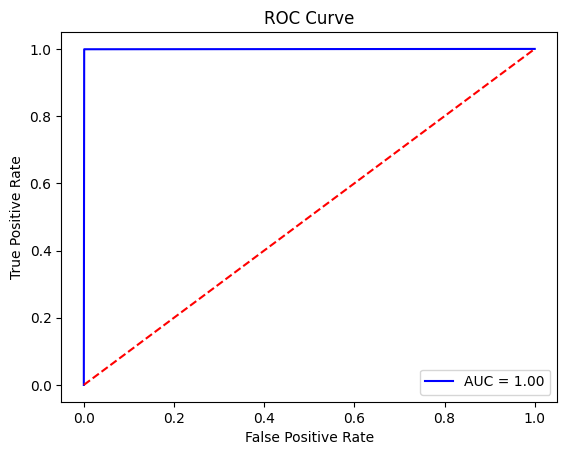

In [48]:
import matplotlib.pyplot as plt
# Plot ROC curve
plt.plot(false_positive_rate, true_positive_rate, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [25]:
print(classification_report(list(test_data.is_address), y_pred_1d))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       409
           1       1.00      1.00      1.00       391

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



In [51]:
x_test = pad_sequences(tokenizer.texts_to_sequences('test haha 123'),
                       maxlen = MAX_SEQUENCE_LENGTH)

In [52]:
%%timeit
scores = loaded_model.predict(x_test, verbose=1, batch_size=10000)

1/1 [==============================] - 0s 19ms/step
36.4 ms ± 852 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
